In [10]:
! pip install mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 30.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 40.0 MB/s eta 0:00:00:00:01

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import torch.nn.functional as F
import torch 
from torch import nn
import torch.optim as optim
import torchvision.transforms as T

from torch.distributions import Categorical
import numpy as np
import pandas as pd
import gym

from collections import deque
from PIL import Image
from tqdm import tqdm

import matplotlib.pyplot as plt

In [15]:
class Actor(nn.Module):
    def __init__(self, input_size, output_size):
        super(Actor, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=256)
        # self.linear2 = nn.Linear(in_features=128, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=output_size)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax()
        # torch.nn.init.xavier_uniform(self.linear1.weight)
        # torch.nn.init.xavier_uniform(self.linear2.weight)
        # torch.nn.init.xavier_uniform(self.linear3.weight)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        # x = self.relu(self.linear2(x))
        x = self.linear3(x)
        output = F.softmax(x, dim=-1)
        return output

class Critic(nn.Module):
    def __init__(self, input_size, output_size):
        super(Critic, self).__init__()
        self.linear1 = nn.Linear(in_features=input_size, out_features=256)
        # self.linear2 = nn.Linear(in_features=128, out_features=256)
        self.linear3 = nn.Linear(in_features=256, out_features=output_size)
        self.relu = nn.ReLU()
        # torch.nn.init.xavier_uniform(self.linear1.weight)
        # torch.nn.init.xavier_uniform(self.linear2.weight)
        # torch.nn.init.xavier_uniform(self.linear3.weight)

    def forward(self, x):
        x = self.relu(self.linear1(x))
        # x = self.relu(self.linear2(x))
        output = self.linear3(x)
        return output

In [16]:


class ActorCritic():
    def __init__(self, env, typ="dense"):
      self.env = env
      self.typ = typ
      self.max_episodes = 5000
      self.max_steps = 400
      self.gamma = 0.99
      self.epsilon = 1.0
      self.epsilon_min = 0.001
      self.epsilon_decay_lamda = self.epsilon_min**(1/self.max_episodes)
      self.target_update_counter = 0
      self.target_update_frequency = 10
      self.buffer_minibatch_size = 120
      self.replay_buffer_capacity=5000
      self.replay_buffer = deque([],maxlen=self.replay_buffer_capacity)

      # _, _, self.state_screen_h, self.state_screen_w = self.screen_preprocessor(self.env.render()).shape
      self.state_count = env.observation_space.shape[0]
      self.action_count = env.action_space.n
      self.actor = Actor(self.state_count, self.action_count)
      self.critic = Critic(self.state_count, 1)#self.action_count) 
      # self.critic_av = Critic(self.state_count, self.action_count) 
      # self.rms_optimizer = optim.RMSprop(self.q_value_dqn.parameters())#, lr=0.001)#, weight_decay=0.05)
      # self.loss_func = F.smooth_l1_loss
      self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=0.0005)#optim.RMSprop(self.q_value_dqn.parameters(), lr=0.001)#, weight_decay=0.05)
      self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=0.001)
      self.loss_func = F.smooth_l1_loss
      
      self.timestep_list = []
      self.rewards_list = []
      self.epsilon_list = []
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

      self.test_max_episodes = 10
      self.test_timestep_list = []
      self.test_rewards_list = []
      self.test_epsilon_list = []
      self.trained_policy_path = "./actor.pth"
    
    def choose_action(self, state, test=False):
      if not test:
          action_prob = self.actor(state)
          actions_cat = Categorical(action_prob)

          current_action = actions_cat.sample()
          action_log_prob = actions_cat.log_prob(current_action)
          return current_action, action_log_prob
      else:
          return self.get_q_value_for_state(state)#.to(self.device))
    
    def get_q_value_for_state(self, state):
      q_values = self.actor(state)
      return q_values.max(1)[1].view(1, 1)

    def eval(self):
      self.actor.load_state_dict(torch.load(self.trained_policy_path))

      for episode in tqdm(range(0, self.test_max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        current_state = torch.from_numpy(obs).unsqueeze(0) 
        while not done:
          current_action = self.choose_action(current_state, test=True)#.to(self.device)
          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())
          self.env.render()
          
          reward_sum += curr_reward
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 

          steps +=1
          
          current_state = next_state
          if reward_sum==200:
            done=True

        self.test_timestep_list.append(steps)
        self.test_rewards_list.append(reward_sum)


    def train(self, current_state, reward, next_state, done, action_log_prob, I):
      
      current_state_val = self.critic(current_state)
      next_state_val = self.critic(next_state) if not done else 0
  
      delta = reward + self.gamma*next_state_val - current_state_val
      actor_loss = (-1*action_log_prob*delta.item()*I)
      critic_loss = (delta**2)
      # print(actor_loss, critic_loss)
      self.actor_optimizer.zero_grad()
      self.critic_optimizer.zero_grad()
      
      loss = actor_loss+critic_loss
      # (actor_loss + critic_loss).backward()
      actor_loss.backward()
      critic_loss.backward()
      # loss.backward()
      for param in self.actor.parameters():
          param.grad.data.clamp_(-5, 5)
      for param in self.critic.parameters():
          param.grad.data.clamp_(-5, 5)
      
      self.actor_optimizer.step()
      self.critic_optimizer.step()

      return actor_loss.item(), critic_loss.item()
      
    def learn(self):
      
      for episode in tqdm(range(0, self.max_episodes), unit='episodes'):
        obs = self.env.reset()[0]
        done = False
        reward_sum = 0
        steps = 0
        a_running_loss=0
        c_running_loss=0
        I = 1
        current_state = torch.from_numpy(obs).unsqueeze(0)
        while not done:
          current_action, action_log_prob = self.choose_action(current_state)

          curr_obs, curr_reward, done, truncated, info = self.env.step(current_action.item())

          reward_sum += curr_reward
          
          next_state = torch.from_numpy(curr_obs).unsqueeze(0) 
  
          actor_loss, critic_loss = self.train(current_state, curr_reward, next_state, done, action_log_prob, I)
          I = self.gamma*I
          steps +=1
          # print(actor_loss,critic_loss)
          a_running_loss += actor_loss
          c_running_loss += critic_loss
          current_state = next_state

          if steps==self.max_steps:# or reward_sum==470:
            done=True

        # self.update_target_net(episode)
            
        self.timestep_list.append(steps)
        self.rewards_list.append(reward_sum)
        self.epsilon_list.append(self.epsilon)
        self.epsilon = max(0.01, self.epsilon*self.epsilon_decay_lamda)
      
        if episode % 100 == 99:
          print(f'[Episode: {episode+1}] - Steps: {sum(self.timestep_list[-100:])/100} | Rewards: {sum(self.rewards_list[-100:])/100} | loss: {a_running_loss / 10:.3f}, {c_running_loss / 10:.3f}')
          a_running_loss = 0.0
          c_running_loss = 0.0
          self.env.render()
          if sum(self.rewards_list[-100:])/100 >= 200:
            break
          # p.print()
        
    def update_target_net(self, episode):
       if episode % self.target_update_frequency == self.target_update_frequency-1:   
          self.critic.load_state_dict(self.actor.state_dict())
    
    def get_minibatch_from_replay_buffer(self):
      exp_batch = random.sample(self.replay_buffer, self.buffer_minibatch_size) #max(len(self.replay_buffer), self.buffer_minibatch_size))
      current_state_batch = torch.cat(tuple([exp[0] for exp in exp_batch]),dim=0)
      current_action_batch = torch.cat(tuple([exp[1] for exp in exp_batch]),dim=0)
      next_state_batch = torch.cat(tuple([exp[3] for exp in exp_batch]),dim=0)
      current_reward_batch = torch.tensor(tuple([exp[2] for exp in exp_batch]))#.to(self.device)
      current_done_batch = torch.tensor(tuple([exp[4] for exp in exp_batch]))#.to(self.device)
      return current_state_batch, current_action_batch, next_state_batch, current_reward_batch, current_done_batch
    
    def add_to_replay_buffer(self, experience):
       self.replay_buffer.append(experience)



In [17]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset()
agent = ActorCritic(env)
agent.learn()

  2%|▏         | 100/5000 [01:50<1:11:09,  1.15episodes/s]

[Episode: 100] - Steps: 262.25 | Rewards: -105.30523338724943 | loss: -3.119, 2460.973


  4%|▍         | 200/5000 [03:57<2:13:04,  1.66s/episodes]

[Episode: 200] - Steps: 261.21 | Rewards: 1.566830040261073 | loss: 1.523, 63.511


  6%|▌         | 300/5000 [05:34<2:13:55,  1.71s/episodes]

[Episode: 300] - Steps: 228.96 | Rewards: -13.574557509866102 | loss: -0.084, 70.685


  8%|▊         | 400/5000 [07:11<1:15:44,  1.01episodes/s]

[Episode: 400] - Steps: 214.83 | Rewards: -12.506162310516887 | loss: -0.327, 101.519


 10%|█         | 500/5000 [09:32<2:43:32,  2.18s/episodes]

[Episode: 500] - Steps: 256.13 | Rewards: 39.99246076454126 | loss: -0.066, 18.218


 12%|█▏        | 600/5000 [11:25<2:15:16,  1.84s/episodes]

[Episode: 600] - Steps: 272.07 | Rewards: 95.6555034500121 | loss: 0.412, 20.613


 14%|█▍        | 700/5000 [14:30<1:36:03,  1.34s/episodes]

[Episode: 700] - Steps: 262.64 | Rewards: 50.762435279980835 | loss: 0.017, 6462.000


 16%|█▌        | 800/5000 [16:47<1:28:01,  1.26s/episodes]

[Episode: 800] - Steps: 240.35 | Rewards: 60.929599670670996 | loss: 1.581, 44.481


 18%|█▊        | 900/5000 [18:43<1:16:27,  1.12s/episodes]

[Episode: 900] - Steps: 256.43 | Rewards: 58.00058951330772 | loss: -0.490, 2659.370


 20%|██        | 1000/5000 [20:24<1:48:56,  1.63s/episodes]

[Episode: 1000] - Steps: 207.64 | Rewards: 39.90869882152944 | loss: -0.264, 12.032


 22%|██▏       | 1100/5000 [22:38<42:23,  1.53episodes/s]  

[Episode: 1100] - Steps: 265.64 | Rewards: 100.26777977349848 | loss: -0.848, 1055.563


 24%|██▍       | 1200/5000 [24:02<1:29:28,  1.41s/episodes]

[Episode: 1200] - Steps: 223.03 | Rewards: 26.759028685064692 | loss: 0.047, 7714.145


 26%|██▌       | 1300/5000 [25:44<1:49:50,  1.78s/episodes]

[Episode: 1300] - Steps: 178.67 | Rewards: 29.294462467525214 | loss: -0.555, 1645.463


 28%|██▊       | 1400/5000 [27:23<1:02:36,  1.04s/episodes]

[Episode: 1400] - Steps: 195.34 | Rewards: 43.29022689215842 | loss: 0.815, 59.721


 30%|███       | 1500/5000 [29:45<48:17,  1.21episodes/s]  

[Episode: 1500] - Steps: 230.58 | Rewards: 69.54803022547827 | loss: -0.060, 745.381


 32%|███▏      | 1600/5000 [30:44<54:29,  1.04episodes/s]  

[Episode: 1600] - Steps: 167.98 | Rewards: 19.972761080438207 | loss: 1.779, 89.650


 34%|███▍      | 1700/5000 [31:36<13:45,  4.00episodes/s]

[Episode: 1700] - Steps: 180.58 | Rewards: 37.52486580726427 | loss: -0.145, 913.685


 36%|███▌      | 1800/5000 [32:47<1:32:34,  1.74s/episodes]

[Episode: 1800] - Steps: 163.88 | Rewards: 17.734305206224995 | loss: 0.327, 38.826


 38%|███▊      | 1900/5000 [34:35<45:58,  1.12episodes/s]  

[Episode: 1900] - Steps: 192.01 | Rewards: 45.70950159380549 | loss: -0.021, 1253.667


 40%|████      | 2000/5000 [36:05<37:57,  1.32episodes/s]  

[Episode: 2000] - Steps: 167.27 | Rewards: 38.32888273402896 | loss: -0.032, 1537.128


 42%|████▏     | 2100/5000 [38:11<53:07,  1.10s/episodes]  

[Episode: 2100] - Steps: 199.93 | Rewards: 30.1985435861702 | loss: 2.220, 70.210


 44%|████▍     | 2200/5000 [39:31<1:04:00,  1.37s/episodes]

[Episode: 2200] - Steps: 137.47 | Rewards: -20.05399745158185 | loss: -0.672, 5972.085


 46%|████▌     | 2300/5000 [41:34<1:26:53,  1.93s/episodes]

[Episode: 2300] - Steps: 150.17 | Rewards: 17.27008599771974 | loss: -0.116, 1794.087


 48%|████▊     | 2400/5000 [43:29<23:41,  1.83episodes/s]  

[Episode: 2400] - Steps: 158.17 | Rewards: 14.90884490898299 | loss: -3.408, 855.731


 50%|█████     | 2500/5000 [45:34<44:59,  1.08s/episodes]  

[Episode: 2500] - Steps: 177.05 | Rewards: 3.087248852224113 | loss: -0.282, 5800.955


 52%|█████▏    | 2600/5000 [47:10<39:20,  1.02episodes/s]  

[Episode: 2600] - Steps: 152.03 | Rewards: 5.14092133921179 | loss: -0.651, 693.542


 54%|█████▍    | 2700/5000 [48:34<26:52,  1.43episodes/s]  

[Episode: 2700] - Steps: 135.68 | Rewards: -10.974415171433714 | loss: 0.388, 2631.597


 56%|█████▌    | 2800/5000 [50:06<50:53,  1.39s/episodes]  

[Episode: 2800] - Steps: 140.81 | Rewards: -19.768759205026583 | loss: -0.030, 732.073


 58%|█████▊    | 2900/5000 [51:19<22:25,  1.56episodes/s]

[Episode: 2900] - Steps: 113.88 | Rewards: -40.65196976717283 | loss: -1.695, 348.777


 60%|██████    | 3000/5000 [52:23<22:23,  1.49episodes/s]

[Episode: 3000] - Steps: 127.37 | Rewards: -15.800310662309975 | loss: -0.806, 614.221


 62%|██████▏   | 3100/5000 [53:33<17:25,  1.82episodes/s]

[Episode: 3100] - Steps: 137.46 | Rewards: -9.73548475876131 | loss: -0.703, 109.779


 64%|██████▍   | 3200/5000 [54:25<13:07,  2.29episodes/s]

[Episode: 3200] - Steps: 108.39 | Rewards: -28.788932520936886 | loss: -0.093, 33.264


 66%|██████▌   | 3300/5000 [55:48<18:23,  1.54episodes/s]  

[Episode: 3300] - Steps: 104.11 | Rewards: -31.734686506583326 | loss: 0.096, 33.150


 68%|██████▊   | 3400/5000 [56:46<08:33,  3.12episodes/s]

[Episode: 3400] - Steps: 100.45 | Rewards: -18.796824745989266 | loss: -0.066, 7.020


 70%|███████   | 3500/5000 [57:20<07:52,  3.17episodes/s]

[Episode: 3500] - Steps: 88.21 | Rewards: -44.71113399556425 | loss: 1.146, 4.730


 72%|███████▏  | 3600/5000 [58:02<08:23,  2.78episodes/s]

[Episode: 3600] - Steps: 98.23 | Rewards: -52.968129817764705 | loss: -0.299, 151.263


 74%|███████▍  | 3700/5000 [58:47<17:20,  1.25episodes/s]

[Episode: 3700] - Steps: 103.45 | Rewards: -43.077440280181605 | loss: 0.111, 579.937


 76%|███████▌  | 3800/5000 [59:38<07:12,  2.77episodes/s]

[Episode: 3800] - Steps: 101.72 | Rewards: -54.93470886746309 | loss: -0.071, 371.438


 78%|███████▊  | 3900/5000 [1:00:21<07:08,  2.57episodes/s]

[Episode: 3900] - Steps: 115.98 | Rewards: -64.22269868088216 | loss: -1.484, 76.265


 80%|████████  | 4000/5000 [1:01:24<07:59,  2.09episodes/s]

[Episode: 4000] - Steps: 140.81 | Rewards: -66.7446834528129 | loss: -0.726, 302.181


 82%|████████▏ | 4100/5000 [1:02:16<04:13,  3.55episodes/s]

[Episode: 4100] - Steps: 128.34 | Rewards: -52.3885593547952 | loss: -0.241, 620.570


 84%|████████▍ | 4200/5000 [1:03:01<09:38,  1.38episodes/s]

[Episode: 4200] - Steps: 144.97 | Rewards: -64.16604141338419 | loss: 0.671, 13.021


 86%|████████▌ | 4300/5000 [1:03:39<03:27,  3.38episodes/s]

[Episode: 4300] - Steps: 128.85 | Rewards: -65.51744400594933 | loss: -0.085, 135.032


 88%|████████▊ | 4400/5000 [1:04:33<03:22,  2.96episodes/s]

[Episode: 4400] - Steps: 148.73 | Rewards: -42.44404071683877 | loss: -0.082, 5737.883


 90%|█████████ | 4501/5000 [1:05:13<02:15,  3.70episodes/s]

[Episode: 4500] - Steps: 131.49 | Rewards: -36.60153026202696 | loss: -0.686, 1146.331


 92%|█████████▏| 4600/5000 [1:05:59<04:46,  1.39episodes/s]

[Episode: 4600] - Steps: 148.94 | Rewards: -9.320785214570959 | loss: -1.584, 4826.297


 94%|█████████▍| 4700/5000 [1:06:52<04:31,  1.10episodes/s]

[Episode: 4700] - Steps: 162.87 | Rewards: -13.937246296704457 | loss: 0.328, 19.475


 96%|█████████▌| 4800/5000 [1:07:43<00:53,  3.75episodes/s]

[Episode: 4800] - Steps: 160.97 | Rewards: -10.632590374750169 | loss: 0.391, 2071.780


 98%|█████████▊| 4900/5000 [1:08:46<00:29,  3.38episodes/s]

[Episode: 4900] - Steps: 148.32 | Rewards: -26.154261718099274 | loss: 0.687, 1425.700


100%|██████████| 5000/5000 [1:09:47<00:00,  1.19episodes/s]

[Episode: 5000] - Steps: 169.34 | Rewards: -18.3938189307371 | loss: -0.481, 7.086


In [20]:
PATH = './actor.pth'
torch.save(agent.actor.state_dict(), PATH)

In [22]:
PATH = './critic.pth'
torch.save(agent.critic.state_dict(), PATH)

In [18]:
epsilon_list_train_dqn = agent.epsilon_list
reward_list_train_dqn = agent.rewards_list

In [9]:
rewardSD_train_dqn_avg = []
for s in np.split(np.array(reward_list_train_dqn), 50):
    rewardSD_train_dqn_avg.append((sum(s)/len(s)))


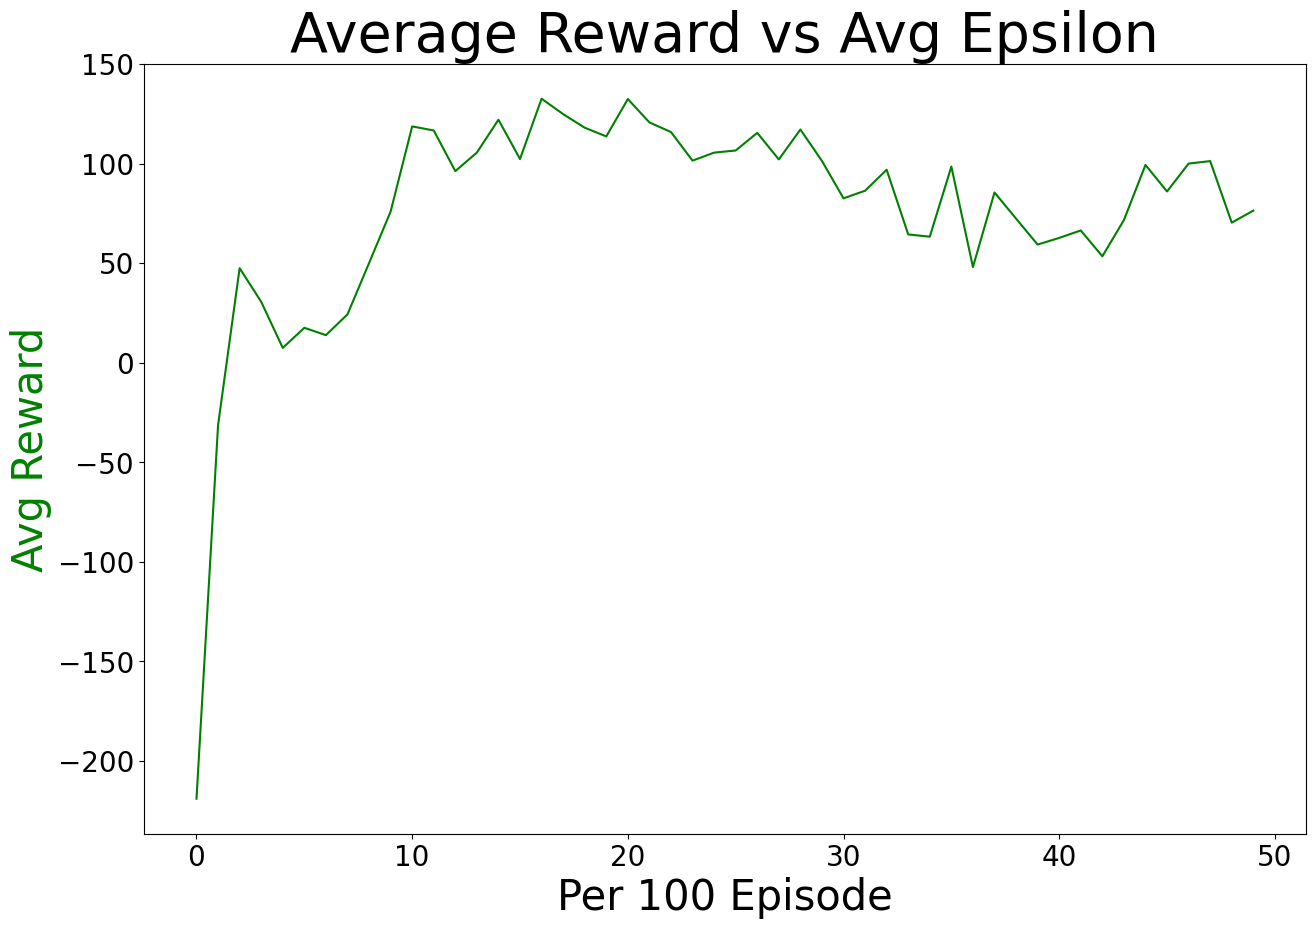

In [10]:
fig, ax2 = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(15)
plt.tick_params(axis='both', which='major', labelsize=20)
ax2.plot(rewardSD_train_dqn_avg, 'g-')
ax2.set_title("Average Reward vs Avg Epsilon", size=40)
ax2.set_xlabel('Per 100 Episode', fontsize=30)
ax2.set_ylabel('Avg Epsilon', color='b', fontsize=30)
ax2.set_ylabel('Avg Reward', color='g', fontsize=30)
plt.show()

In [ ]:
import json
with open('reward.json', 'w') as f:
    json.dump(reward_list_train_dqn, f)

# import json
# with open('backup/epsilon.json') as f:
#     epsilon_list_train_dqn = json.load(f)

In [38]:
env = gym.make('LunarLander-v2', render_mode="rgb_array")
env.reset()
agent_test = ActorCritic(env)
agent_test.eval()

100%|██████████| 10/10 [00:30<00:00,  3.06s/episodes]


In [39]:
reward_list_test_dqn = agent_test.test_rewards_list

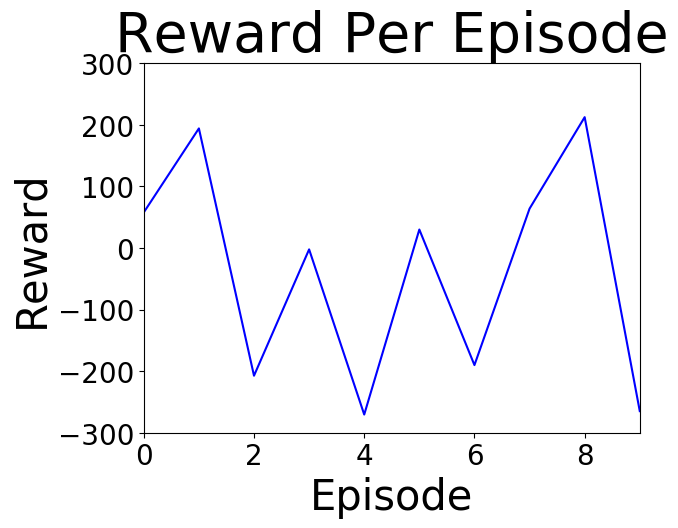

In [40]:
fig, (ax2) = plt.subplots(1,1)
# fig.set_figheight(50)
# fig.set_figwidth(50)
# ax1.plot(epsilon_list_train_dqn, 'go')
# ax1.set_title("Epsilon Decay", size=40)
# ax1.set_ylabel('Epsilon Value', fontsize = 30) 
# ax1.set_xlabel('Episode', fontsize = 30)
# ax1.tick_params(axis='x', labelsize=20)
# ax1.tick_params(axis='y', labelsize=20)
# ax1.set_xlim(100)
# ax1.set_xlim(xmin=0, xmax=3800)
# ax1.set_ylim(ymin=0, ymax=1)
ax2.plot(reward_list_test_dqn, 'b-')
ax2.set_title(f"Reward Per Episode", size=40)
ax2.set_ylabel('Reward', fontsize = 30) 
ax2.set_xlabel('Episode', fontsize = 30)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_xlim(xmin=0, xmax=9)
ax2.set_ylim(ymin=-300, ymax=300)
plt.show()